# **Assignment11.0**

In [2]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/dataset/Train/'
# load dataset A
dataA1 = load_images(path + 'Train_Lime/')
dataAB = load_images(path + 'Val_Lime/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'Train_Apple/')
dataB2 = load_images(path + 'Val_Apple/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = '/content/drive/MyDrive/Colab Notebooks/dataset/Train/Output/orange2pomelo_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (40, 256, 256, 3)
Loaded dataB:  (40, 256, 256, 3)
Saved dataset:  /content/drive/MyDrive/Colab Notebooks/dataset/Train/Output/orange2pomelo_256.npz


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded:  (40, 256, 256, 3) (40, 256, 256, 3)


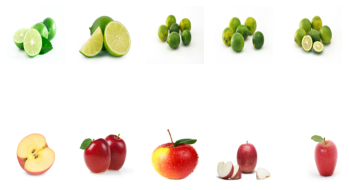

In [4]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('/content/drive/MyDrive/Colab Notebooks/dataset/Train/Output/orange2pomelo_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 5
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fetcyklm
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fetcyklm
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=1bb0a3e6a2821bbde8005c260ac060da669a79924c1168f8edab20b30296c5cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-_87vm57s/wheels/67/d2/f4/96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [6]:
!git clone https://www.github.com/keras-team/keras-contrib.git
%cd keras-contrib
!python setup.py install

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 605.00 KiB/s, done.
Resolving deltas: 100% (2330/2330), done.
/content/keras-contrib
running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_contrib
copying keras_contrib/__init__.py -> build/lib/keras_contrib
creating build/lib/keras_contrib/back

In [8]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 20, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

# load image data
dataset = load_real_samples('/content/drive/MyDrive/Colab Notebooks/dataset/Train/Output/orange2pomelo_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (40, 256, 256, 3) (40, 256, 256, 3)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 628ms/step
>1, dA[1.882,0.988] dB[1.149,1.369] g[24.055,27.194]
1/1 [==============================] - 0s 21ms/step
>2, dA[13.949,4.216] dB[5.522,1.929] g[22.417,23.045]
1/1 [==============================] - 0s 20ms/step
>3, dA[2.589,3.775] dB[6.852,3.367] g[28.028,21.375]
1/1 [==============================] - 0s 19ms/step
>4, dA[1.766,3.378] dB[11.195,3.974] g[24.983,19.682]
1/1 [==============================] - 0s 19ms/step
>5, dA[1.949,1.377] dB[5.916,2.362] g[20.614,19.431]
1/1 [==============================] - 0s 19ms/step
>6, dA[1.515,0.499] dB[1.524,0.728] g[19.424,19.307]
1/1 [==============================] - 0s 21ms/step
>7, dA[1.134,0.614] dB[0.852,0.781] g[18.263,18.073]
1/1 [==============================] - 0s 19ms/step
>8, dA[0.699,1.457] dB[1.885,0.940] g[19.679,18.665]
1/1 [==============================] - 0s 20ms/step
>9, dA[0.554,1.096] dB[1.698,0.904] g[16.314,15.333]
1/1 [==============================] - 0s 20ms/step


>Saved: g_model_AtoB_000200.h5 and g_model_BtoA_000200.h5
1/1 [==============================] - 0s 20ms/step
>201, dA[0.028,0.029] dB[0.019,0.061] g[14.948,16.374]
1/1 [==============================] - 0s 21ms/step
>202, dA[0.011,0.030] dB[0.030,0.008] g[11.387,12.854]
1/1 [==============================] - 0s 23ms/step
>203, dA[0.023,0.007] dB[0.027,0.151] g[12.410,11.643]
1/1 [==============================] - 0s 20ms/step
>204, dA[0.025,0.092] dB[0.074,0.049] g[12.947,13.825]
1/1 [==============================] - 0s 21ms/step
>205, dA[0.106,0.066] dB[0.034,0.036] g[12.082,12.356]
1/1 [==============================] - 0s 22ms/step
>206, dA[0.228,0.040] dB[0.059,0.034] g[11.893,10.772]
1/1 [==============================] - 0s 19ms/step
>207, dA[0.141,0.062] dB[0.011,0.020] g[10.804,11.052]
1/1 [==============================] - 0s 20ms/step
>208, dA[0.056,0.206] dB[0.025,0.047] g[10.117,10.433]
1/1 [==============================] - 0s 21ms/step
>209, dA[0.155,0.031] dB[0.028,0.1

>Saved: g_model_AtoB_000400.h5 and g_model_BtoA_000400.h5
1/1 [==============================] - 0s 22ms/step
>401, dA[0.016,0.114] dB[0.008,0.012] g[13.046,11.716]
1/1 [==============================] - 0s 20ms/step
>402, dA[0.260,0.077] dB[0.009,0.002] g[9.932,9.549]
1/1 [==============================] - 0s 23ms/step
>403, dA[0.036,0.015] dB[0.007,0.021] g[13.864,14.066]
1/1 [==============================] - 0s 24ms/step
>404, dA[0.141,0.094] dB[0.110,0.276] g[9.009,9.893]
1/1 [==============================] - 0s 21ms/step
>405, dA[0.032,0.025] dB[0.048,0.067] g[12.867,11.852]
1/1 [==============================] - 0s 20ms/step
>406, dA[0.021,0.031] dB[0.073,0.025] g[13.809,14.175]
1/1 [==============================] - 0s 22ms/step
>407, dA[0.018,0.029] dB[0.040,0.024] g[11.346,12.960]
1/1 [==============================] - 0s 22ms/step
>408, dA[0.053,0.026] dB[0.029,0.014] g[9.603,9.574]
1/1 [==============================] - 0s 21ms/step
>409, dA[0.035,0.022] dB[0.014,0.036] g[

>Saved: g_model_AtoB_000600.h5 and g_model_BtoA_000600.h5
1/1 [==============================] - 0s 21ms/step
>601, dA[0.128,0.061] dB[0.057,0.028] g[10.583,10.745]
1/1 [==============================] - 0s 20ms/step
>602, dA[0.062,0.070] dB[0.022,0.102] g[11.262,10.681]
1/1 [==============================] - 0s 20ms/step
>603, dA[0.099,0.043] dB[0.065,0.028] g[10.942,11.977]
1/1 [==============================] - 0s 22ms/step
>604, dA[0.074,0.038] dB[0.044,0.080] g[10.396,10.767]
1/1 [==============================] - 0s 22ms/step
>605, dA[0.046,0.102] dB[0.120,0.009] g[12.153,13.348]
1/1 [==============================] - 0s 20ms/step
>606, dA[0.054,0.016] dB[0.040,0.068] g[9.100,10.076]
1/1 [==============================] - 0s 21ms/step
>607, dA[0.057,0.063] dB[0.121,0.031] g[10.705,11.296]
1/1 [==============================] - 0s 21ms/step
>608, dA[0.008,0.024] dB[0.016,0.015] g[12.415,12.964]
1/1 [==============================] - 0s 21ms/step
>609, dA[0.131,0.082] dB[0.007,0.01

>Saved: g_model_AtoB_000800.h5 and g_model_BtoA_000800.h5


1/1 [==============================] - 1s 661ms/step


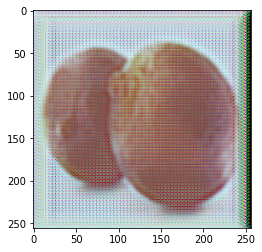

In [10]:
# example of using saved cyclegan models for image translation
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from matplotlib import pyplot

# load an image to the preferred size
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

# load the image
image_src = load_image('/content/drive/MyDrive/Colab Notebooks/dataset/Train/Train_Lime/5.jpg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_000800.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()

1/1 [==============================] - 1s 661ms/step


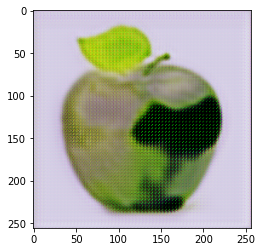

In [13]:
# load the image
image_src = load_image('/content/drive/MyDrive/Colab Notebooks/dataset/Train/Train_Apple/26.jpg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_BtoA_000800.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()